# WMS to RASTER 

In [ ]:
import requests
import numpy as np
import rioxarray
from shapely.geometry import mapping
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from osgeo import gdal
from owslib.wms import WebMapService
from rasterio import MemoryFile
from rasterio.plot import show

<Axes: >

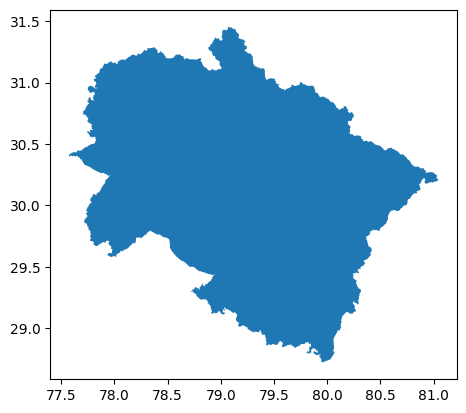

In [28]:
shp=gpd.read_file(r"C:\Project _Final\Shapefile\Uttarakhand.zip")#read shapefile
shp.plot()

In [29]:
tuple(shp.bounds.values[0]) #bounds of shape file for clipping

(77.57230026174163, 28.722894906447042, 81.04528735631932, 31.456126767118253)

In [31]:
url = "https://bhuvan-ras2.nrsc.gov.in/cgi-bin/LULC250K.exe" # urlto wms layer
wms = WebMapService(url)

https://owslib.readthedocs.io/en/latest/usage.html#wms

In [32]:
wms.contents #layers in WMS

OrderedDict([('lulc250k_bhuvan',
              <owslib.map.wms111.ContentMetadata at 0x1a9878bd0f0>),
             ('LULC250K_0405',
              <owslib.map.wms111.ContentMetadata at 0x1a9878bd060>),
             ('LULC250K_0506',
              <owslib.map.wms111.ContentMetadata at 0x1a9878d5900>),
             ('LULC250K_0607',
              <owslib.map.wms111.ContentMetadata at 0x1a9878d5b40>),
             ('LULC250K_0708',
              <owslib.map.wms111.ContentMetadata at 0x1a9878d5a20>),
             ('LULC250K_0809',
              <owslib.map.wms111.ContentMetadata at 0x1a9878d5c30>),
             ('LULC250K_0910',
              <owslib.map.wms111.ContentMetadata at 0x1a9878d5bd0>),
             ('LULC250K_1011',
              <owslib.map.wms111.ContentMetadata at 0x1a9878d5c90>),
             ('LULC250K_1112',
              <owslib.map.wms111.ContentMetadata at 0x1a9878d5b70>),
             ('LULC250K_1213',
              <owslib.map.wms111.ContentMetadata at 0x1a9878d5d20>)

In [34]:
wms['LULC250K_0506'].styles #legend

{'default': {'title': 'default',
  'legend': 'https://bhuvan-ras2.nrsc.gov.in/cgi-bin/mapserv.exe?map=/ms4w/apps/mapfiles/LULC250K.map&version=1.1.1&service=WMS&request=GetLegendGraphic&layer=LULC250K_0506&format=image/png&STYLE=default'}}

In [39]:
wms['LULC250K_0506'].boundingBox # bounding box of wms

(63.3515, 5.07729, 100.82, 38.2858, 'EPSG:4326')

In [ ]:
#SIZE
width,height=1662,1313

In [8]:
img = wms.getmap(
    layers = ["LULC250K_0708"],
    srs = 'EPSG:4326',
    bbox = tuple(shp.bounds.values[0]),
    format = 'image/tiff',
    size=(width,height)
)

IMAGE


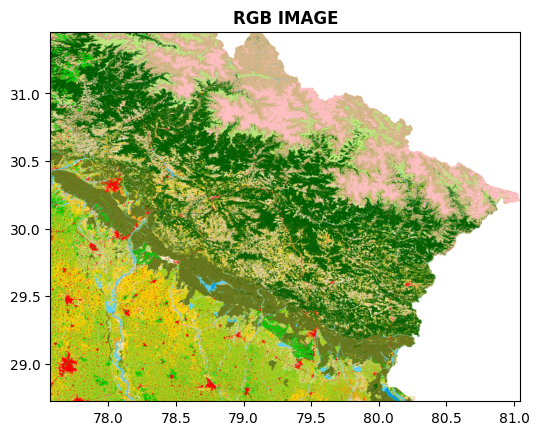

Data Details
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1662, 'height': 1313, 'count': 3, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.0020896432578686418, 0.0, 77.57230026174163,
       0.0, -0.0020816693531387743, 31.456126767118253), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


In [42]:
with MemoryFile(img) as memfile:# read image as temporary memory aand load in Xarray for processing
     with memfile.open() as dataset:
            print("IMAGE")
            show(dataset,title="RGB IMAGE")
            array2=xr.open_dataset(dataset,engine='rasterio')
            print("Data Details\n",dataset.profile)

In [43]:
anew=array2.rio.clip(shp.geometry.apply(mapping),shp.crs,all_touched=True)#clip to geometry using shapefile
anew

<xarray.Dataset>
Dimensions:      (band: 3, x: 1662, y: 1313)
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 77.57 77.58 77.58 77.58 ... 81.04 81.04 81.04 81.04
  * y            (y) float64 31.46 31.45 31.45 31.45 ... 28.73 28.73 28.73 28.72
    spatial_ref  int32 0
Data variables:
    band_data    (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan

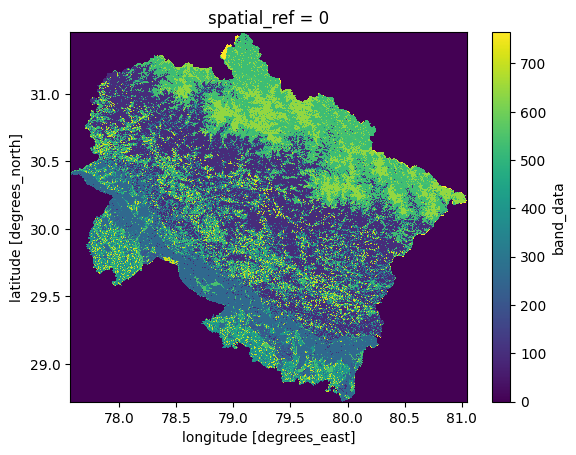

In [45]:
anew["band_data"].sum(dim="band").plot()# sample plot of dataset

In [12]:
data=anew["band_data"].to_numpy()#convert to numpy array for processing
print(np.shape(data))
arr6=[]

(3, 1313, 1662)


INDEX EXTRACTION

In [50]:
length=np.shape(np.where(anew["band_data"].sum(dim="band")!=0)[0])
length

(1154925,)

In [47]:
x,y=np.where(anew["band_data"].sum(dim="band")!=0) #indexes

In [15]:
arr6=[] # imaage to array
for p in range(0,length[0]):
            arr6.append(tuple(data[:,x[p],y[p]]))

In [16]:
res = list(dict.fromkeys(arr6)) # unique RGB combinations
res

[(209.0, 181.0, 133.0),
 (255.0, 191.0, 196.0),
 (94.0, 209.0, 242.0),
 (0.0, 94.0, 0.0),
 (255.0, 255.0, 255.0),
 (115.0, 184.0, 43.0),
 (158.0, 207.0, 31.0),
 (245.0, 245.0, 219.0),
 (184.0, 235.0, 120.0),
 (107.0, 120.0, 31.0),
 (255.0, 209.0, 0.0),
 (158.0, 82.0, 43.0),
 (255.0, 0.0, 0.0),
 (0.0, 204.0, 0.0),
 (255.0, 158.0, 0.0),
 (0.0, 158.0, 222.0),
 (5.0, 130.0, 94.0)]

In [17]:
number_of_pixels_foreach_class=[x*0 for x in range(0,len(res))] # array for counting number of pixels
np.shape(number_of_pixels_foreach_class)

(17,)

In [18]:
final_array=np.zeros(len(arr6), dtype='int64')# assigning classes to to image and counting number of pixels
for p in range(0,np.shape(x)[0]):
    for q in range(0,len(res)):
            if arr6[p]==res[q]:
                    final_array[p]=q+1
                    number_of_pixels_foreach_class[q]+=1

In [19]:
number_of_pixels_foreach_class

[244475,
 86604,
 19564,
 321912,
 2316,
 37080,
 70206,
 55218,
 39210,
 213391,
 36300,
 870,
 13011,
 10994,
 3173,
 574,
 27]

In [20]:
k=np.zeros(shape=height,width),dtype='int64')
for p in range(0,np.shape(y)[0]): #array to image
        k[x[p],y[p]]=final_array[p]

In [35]:
#save as geotfiff single band
def read_geotiff(filename):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr, ds

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_UInt16
    else:
        arr_type = gdal.GDT_UInt16

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.SetNoDataValue(0)
    band.FlushCache()
    band.ComputeStatistics(False)

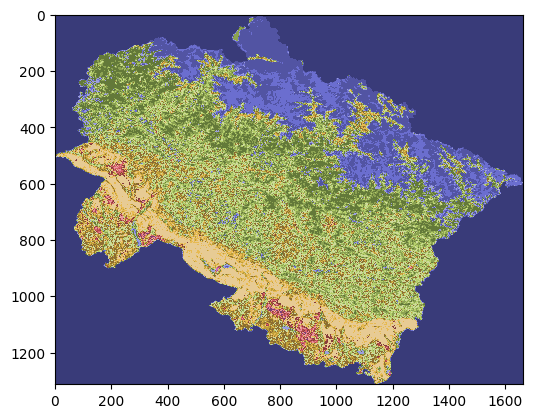

In [48]:

plt.imshow(k,cmap="tab20b")

In [37]:
filename_i=r"C:\Project _Final\paper\LULC\reference\reference.tif"# path of input reference image
a,b=read_geotiff(filename_i) #read reference tiff image for saving tiff image 

In [49]:
filename_o=r"C:\Project _Final\paper\test\\test.tif"##output image location

write_geotiff(filename_o,k, b) ## writing astiff image